<h1 align="center">In The Name Of God</h1>
<h1 align="center">An Introduction to Machine Learning</h3>
<h4 align="center">Sharif University of Technology, Autumn 2024</h4>
<h4 align="center">Taha Abedini, Mohammad Mahdy Azarian</h4>

## Loading And Displaying Binarized MNIST Images

This code loads the MNIST dataset, which consists of images of handwritten digits. It converts the pixel values of the images into binary (black and white) by applying a threshold of 128. Then, it randomly selects 10 images from the binarized training set and displays them using Matplotlib, showing the corresponding labels (digit classes) for each image. The images are visualized in grayscale with no axis, presenting a clear and simplified representation of the digits.

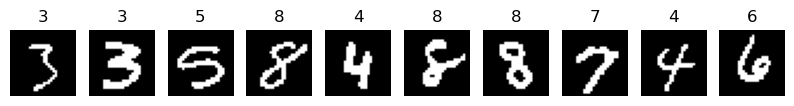

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Apply a threshold to convert pixel intensities to binary (e.g., 128)
threshold = 128
x_train_binary = (x_train > threshold).astype(np.float32)
x_test_binary = (x_test > threshold).astype(np.float32)

# Function to display a few images
def plot_images(images, labels, num_images=10):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

# Display 10 random binarized images from the training set
random_indices = np.random.choice(x_train_binary.shape[0], 10, replace=False)
plot_images(x_train_binary[random_indices], y_train[random_indices], num_images=10)


## Training and Visualizing RBM with Contrastive Divergence

This code defines and trains a Restricted Boltzmann Machine (RBM) on a dataset (such as MNIST) using the Contrastive Divergence (CD) algorithm. The RBM is initialized with visible and hidden units, and the model undergoes training for several epochs with different values of `k` (the number of Gibbs sampling steps for the negative phase). After training, it generates samples using the learned weights and biases. These generated samples are displayed in a sequence, and an animation of the generated samples at each Gibbs step is created for visualization. The code also includes functions for visualizing the samples generated with varying `k` values.

In [6]:
import matplotlib.animation as animation
import copy
from IPython.display import HTML

class RBM:
    def __init__(self, visible_units, hidden_units, learning_rate=0.1, k_values=[1, 5, 10]):
        self.visible_units = visible_units  # Number of visible units
        self.hidden_units = hidden_units  # Number of hidden units
        self.learning_rate = learning_rate  # Learning rate
        self.samples = []   # Saving samples
        self.k_values = k_values

        # Initialize weights and biases
        self.W = np.random.randn(self.visible_units, self.hidden_units) * 0.1  # Weight matrix
        self.initial_W = copy.copy(self.W)
        self.bh = np.zeros(self.hidden_units)  # Hidden bias
        self.bv = np.zeros(self.visible_units)  # Visible bias

    def sigmoid(self, x):
        """Sigmoid activation function."""
        return 1.0 / (1.0 + np.exp(-x))

    def contrastive_divergence(self, v0, k=1):
        """Contrastive Divergence with k steps."""
        # Positive phase
        h0_prob = self.sigmoid(np.dot(v0, self.W) + self.bh)  # Hidden probabilities
        h0 = (h0_prob > np.random.binomial(1, 0.5, size=h0_prob.shape)).astype(np.float32)  # Sample hidden states

        # Negative phase (Gibbs sampling for k steps)
        vk = v0
        hk = h0
        samples = [v0]  # To store the samples at each step

        for step in range(k):
            # Reconstruct visible layer from hidden layer
            vk_prob = self.sigmoid(np.dot(hk, self.W.T) + self.bv)  # Visible probabilities
            vk = (vk_prob > np.random.binomial(1, 0.5, size=vk_prob.shape)).astype(np.float32)  # Sample visible states

            # Reconstruct hidden layer from visible layer
            hk_prob = self.sigmoid(np.dot(vk, self.W) + self.bh)  # Hidden probabilities
            hk = (hk_prob > np.random.binomial(1, 0.5, size=hk_prob.shape)).astype(np.float32)  # Sample hidden states

            # Store the current visible sample
            samples.append(vk)

        # Update weights and biases
        positive_grad = np.dot(v0.T, h0)
        negative_grad = np.dot(vk.T, hk)

        self.W += self.learning_rate * (positive_grad - negative_grad) / len(v0)
        self.bh += self.learning_rate * np.mean(h0 - hk, axis=0)
        self.bv += self.learning_rate * np.mean(v0 - vk, axis=0)

        return samples

    def train(self, x_train, epochs=10):
        """Train the RBM using Contrastive Divergence for different k values."""
        for k in self.k_values:
          self.W = self.initial_W
          print(f"Training with k={k}...")
          for epoch in range(epochs):
            for data in x_train:
              self.contrastive_divergence(data.reshape(1, -1), k)
            print(f"Epoch {epoch + 1}/{epochs} completed")
          self.generate_samples(k)

    def generate_samples(self, k):
        print(f"Generating samples with k={k}...")
        samples_num = 5
        for i in range(samples_num):
          v = np.random.binomial(1, 0.5, size=(1, self.visible_units))  #initialization
          # Get the samples at each Gibbs step
          self.samples.append(self.contrastive_divergence(v, k))

    def display_samples(self):
        """Display the generated samples."""
        for i in range(3):
          # Plot each sample
          fig, axes = plt.subplots(1, 5, figsize=(15, 3))
          for i, sample in enumerate(self.samples[5*i: 5*(i+1)]):
            axes[i].imshow(sample[-1].reshape(28, 28), cmap='gray')
            axes[i].axis('off')

          plt.suptitle(f"Generated Samples for k={len(sample)-1}")
          plt.show()

    def create_and_display_animation(self):
        for sample_steps in self.samples:
            fig, ax = plt.subplots(figsize=(5, 5))
            ims = []
            for j, sample in enumerate(sample_steps):
                im = ax.imshow(sample.reshape(28, 28), cmap='gray', animated=True)
                ax.set_title(f"k = {len(sample_steps)-1}")
                ims.append([im])
            ani = animation.ArtistAnimation(fig, ims, interval=500,
                                            blit=True, repeat_delay=1000)
            # Display the animation as an HTML5 video
            display(HTML(ani.to_html5_video()))
            plt.close(fig)


In [ ]:

rbm = RBM(visible_units=784, hidden_units=128, learning_rate=0.075, k_values=[1, 5, 10])

# Train the RBM with different values of k (1, 5, 10)
rbm.train(x_train_binary, epochs=5)

rbm.display_samples()

In [8]:
rbm.create_and_display_animation()

## Conditional RBM for Label-Conditioned Image Generation

#### 1. **Conditioning the Model with Labels**
- Extend the RBM to include **label units** in the visible layer.
- For MNIST, attach a one-hot encoded vector representing the digit label to the visible layer.
- During training:
  - Concatenate the digit label with the image data to form the extended visible input.
- During generation:
  - Fix the desired label in the one-hot encoding and let the RBM generate corresponding image samples.

This transforms the RBM into a **Conditional RBM (CRBM)**, allowing it to learn label-specific patterns during training.

#### 2. **Fine-Tuning the Model**
- Use pre-trained weights from an unsupervised RBM.
- Fine-tune the model in a supervised manner using label-specific data.
- Alternatively, train separate RBMs for each digit (e.g., train 10 RBMs for digits 0 to 9).

#### 3. **Latent Space Interpolation**
- Utilize hidden units (latent space) associated with specific patterns learned during training.
- Map back to visible units and enforce constraints that align with desired digits.

#### 4. **Post-Training Sampling**
- Generate a large number of samples using the RBM.
- Use a classifier to filter samples that match the target digit.
- Retain only the samples classified as the desired digit for further use.

### Implementation Plan
1. **Extend the RBM Architecture**:
   - Modify the visible layer to include label units.
   - Implement training logic that incorporates both image data and labels.

2. **Train the Conditional RBM (CRBM)**:
   - Train the model on the MNIST dataset with labeled data.

3. **Generate Controlled Samples**:
   - Fix the label during the sampling process to generate desired outputs.

4. **Alternative Filtering Method**:
   - Use a pre-trained classifier to filter and identify samples matching the target digit.

### Challenges and Considerations
- **Training Complexity**: Adding label conditioning increases training time and model complexity.
- **Generalization**: Overfitting to labels could reduce the model's generalization ability.
- **Sample Quality**: The quality of generated samples depends on the RBM's ability to learn label-specific features.

By implementing these approaches, the RBM can be adapted for controlled sample generation, making it capable of generating specific digit outputs.


In [8]:
class ConditionalRBM(RBM):
    def __init__(self, visible_units, hidden_units, num_labels, learning_rate=0.1):
        super().__init__(visible_units + num_labels, hidden_units, learning_rate)
        self.num_labels = num_labels  # Number of possible labels (e.g., 10 for MNIST)

    def train_with_labels(self, x_train, y_train, epochs=10, k=1):
      for epoch in range(epochs):
        for x, y in zip(x_train, y_train):
              # Flatten the image data if it's not already flattened
              x_flattened = x.flatten()  # Ensures the image is a 1D array
              label = np.zeros(self.num_labels)
              label[int(y)] = 1  # One-hot encode the label

              # Concatenate flattened image data with one-hot encoded label
              v0 = np.concatenate([x_flattened, label]).reshape(1, -1)

              # Perform contrastive divergence
              self.contrastive_divergence(v0, k)
        print(f"Epoch {epoch + 1}/{epochs} completed.")

    def generate_label_conditioned_sample(self, label, k=1):
        """Generate a sample conditioned on a specific label."""
        # Initialize the visible layer with random noise and set the label
        v = np.random.binomial(1, 0.5, (1, self.visible_units - self.num_labels))
        label_vector = np.zeros((1, self.num_labels))
        label_vector[0, label] = 1  # Set the desired label
        v = np.concatenate([v, label_vector], axis=1)

        # Perform Gibbs sampling
        samples = self.contrastive_divergence(v, k)
        return samples[-1][:self.visible_units - self.num_labels]  # Return only the image part


## Training Conditional RBM on MNIST with Label Conditioning

In [11]:
# Assume x_train_binary and y_train are loaded and preprocessed
crbm = ConditionalRBM(visible_units=784, hidden_units=128, num_labels=10, learning_rate=0.05)

# Train the Conditional RBM
crbm.train_with_labels(x_train_binary, y_train, epochs=10, k= 10)

C:\Users\Taha\AppData\Local\Temp\ipykernel_17292\3858483008.py:21: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


Epoch 1/10 completed.
Epoch 2/10 completed.
Epoch 3/10 completed.
Epoch 4/10 completed.
Epoch 5/10 completed.
Epoch 6/10 completed.
Epoch 7/10 completed.
Epoch 8/10 completed.
Epoch 9/10 completed.
Epoch 10/10 completed.


## Generating and Visualizing Label-Conditioned Samples for Each Digit

This code generates and visualizes images for each digit (0-9) using the trained Conditional Restricted Boltzmann Machine (CRBM). For each digit, the `generate_label_conditioned_sample` method is called with the desired label (digit), and Gibbs sampling with `k = 10` steps is performed to generate the corresponding image. After the sample is generated, the image portion (first 784 elements, representing the visible layer) is extracted, reshaped into a 28x28 format, and displayed using Matplotlib. Each generated sample is shown with its corresponding digit label as the title.


Generating sample for digit 0...


C:\Users\Taha\AppData\Local\Temp\ipykernel_17292\3858483008.py:21: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


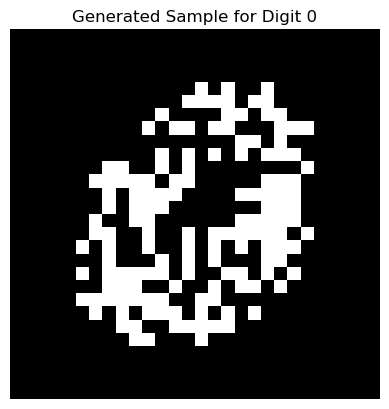

Generating sample for digit 1...


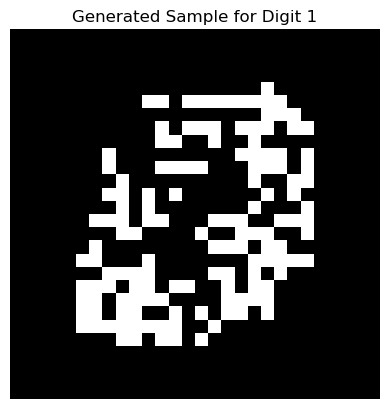

Generating sample for digit 2...


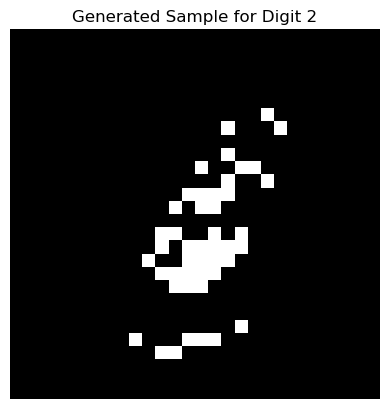

Generating sample for digit 3...


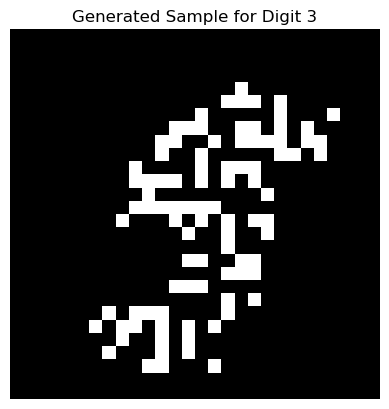

Generating sample for digit 4...


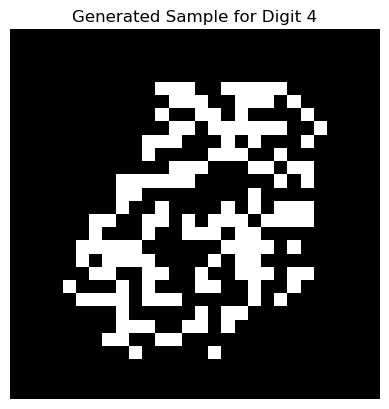

Generating sample for digit 5...


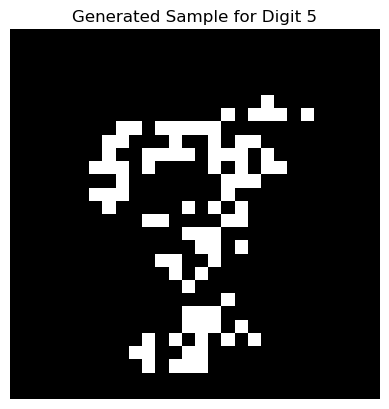

Generating sample for digit 6...


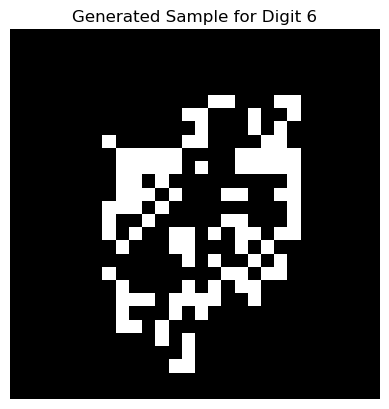

Generating sample for digit 7...


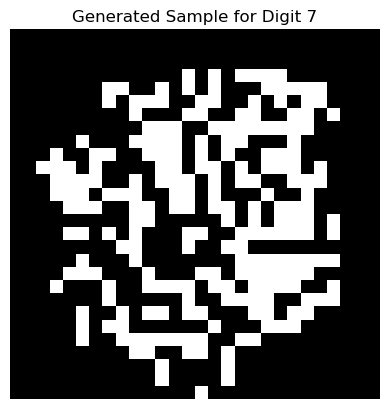

Generating sample for digit 8...


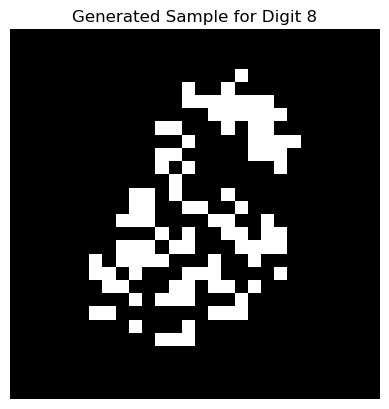

Generating sample for digit 9...


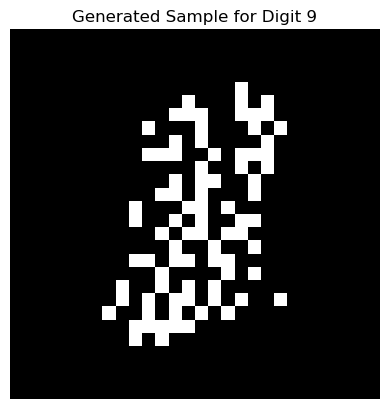

In [12]:
# Generate samples for specific digits
for digit in range(10):  # Generate for digits 0-9
    print(f"Generating sample for digit {digit}...")
    sample = crbm.generate_label_conditioned_sample(digit, k= 5)

    # Extract the image portion of the sample (first 784 elements)
    image_sample = sample[0, :784]

    # Visualize the generated sample
    plt.imshow(image_sample.reshape(28, 28), cmap='gray')
    plt.title(f"Generated Sample for Digit {digit}")
    plt.axis('off')
    plt.show()
